In [345]:
import os
import collections
import pretty_midi
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt

In [346]:
def estimate_key_from_midi(file_path):
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(file_path)

    # Gather all notes from all instruments
    all_notes = [note.pitch for instrument in midi_data.instruments for note in instrument.notes]

    # Compute pitch class distribution
    note_counts = np.zeros(12)
    for note in all_notes:
        note_counts[note % 12] += 1

    # Normalize the distribution
    note_counts /= np.sum(note_counts)

    # Define Krumhansl-Schmuckler key profiles for major and minor
    major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

    # Calculate correlations with major and minor profiles for all 12 root pitches
    major_correlations = [np.correlate(note_counts, np.roll(major_profile, -i))[0] for i in range(12)]
    minor_correlations = [np.correlate(note_counts, np.roll(minor_profile, -i))[0] for i in range(12)]

    # Find the index of the highest correlation
    best_key_index = np.argmax(major_correlations + minor_correlations)

    # Determine the mode and key
    if best_key_index < 12:
        mode = 'major'
        key = pretty_midi.note_number_to_name(best_key_index).replace('0', '')
    else:
        mode = 'minor'
        key = pretty_midi.note_number_to_name(best_key_index - 12).replace('0', '')

    return key, mode

def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['velocity'].append(note.velocity)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def create_key_mask(root_note, mode):
    # Note indices: C, C#, D, D#, E, F, F#, G, G#, A, A#, B
    major_scale_intervals = [0, 2, 4, 5, 7, 9, 11]
    minor_scale_intervals = [0, 2, 3, 5, 7, 8, 10]
    
    if mode == 'major':
        valid_notes = [(root_note + interval) % 12 for interval in major_scale_intervals]
    else:  # minor mode
        valid_notes = [(root_note + interval) % 12 for interval in minor_scale_intervals]

    # Create a mask for all 128 MIDI notes
    mask = np.ones(128) * 1e9  # High penalty for out-of-key notes
    for note in range(128):
        if note % 12 in valid_notes:
            mask[note] = 0  # No penalty for in-key notes
    
    return mask

def key_specific_loss(mask):
    mask_tensor = tf.constant(mask, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Apply the key mask: penalize predictions by adding the mask values
        y_pred_adjusted = y_pred - mask_tensor
        
        # Use sparse categorical crossentropy as the base loss
        return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred_adjusted, from_logits=False)

    return loss

In [347]:
base_dir = 'EMOPIA_2.2/midis/'
midis = os.listdir(base_dir)

# choose a random midi file
midi_file = np.random.choice(midis)

key = estimate_key_from_midi(base_dir + midi_file)
print(key)
mask = create_key_mask(pretty_midi.note_name_to_number(key[0]), key[1]) # we utelize a loss function to penalize out-of-key notes

print(midi_file)

file = base_dir + midi_file

############### FOR TESTING, LET'S DEFINE A NON-RANDOM MIDI FILE  ###############
# file = 'content/midis/Q2_fuCxYrru2S4_2.mid'
############### FOR TESTING, LET'S DEFINE A NON-RANDOM MIDI FILE  ###############

notes = midi_to_notes(file)
notes

('G#-1', 'major')
Q4_MT2_mXn-vGU_1.mid


,pitch,velocity,start,end,step,duration
0,64,52,0.042969,0.329427,0.000000,0.286458
1,57,46,0.042969,0.789062,0.000000,0.746094
2,63,36,0.078125,1.139323,0.035156,1.061198
3,64,73,0.335938,3.059896,0.257812,2.723958
4,47,37,0.338542,0.949219,0.002604,0.610677
...,...,...,...,...,...,...
201,78,52,37.920573,38.968750,0.006510,1.048177
202,75,56,38.490885,39.000000,0.570312,0.509115
203,66,66,38.513021,38.949219,0.022135,0.436198
204,80,71,38.535156,38.886719,0.022135,0.351562


In [348]:
def create_model(input_shape, learning_rate):
    inputs = tf.keras.Input(shape=input_shape, name='Input_Layer')

    # Base LSTM layers with attention
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, name='LSTM_Base'))(inputs)
    x = tf.keras.layers.Attention(name='Attention_Base')([x, x])

    # Additional LSTM + Attention layers for deep feature extraction
    # for i in range(3):
    #     lstm_layer = tf.keras.layers.LSTM(512, return_sequences=True, name=f'LSTM_{i}')
    #     x = tf.keras.layers.Bidirectional(lstm_layer)(x)
    #     x = tf.keras.layers.Attention(name=f'Attention_{i}')([x, x])

    # Final LSTM layer before branching
    final_lstm_layer = tf.keras.layers.LSTM(64, return_sequences=False, name='LSTM_Final')
    x = tf.keras.layers.Bidirectional(final_lstm_layer)(x)

    # Branch for categorical outputs
    x_cat = tf.keras.layers.Dense(128, activation='relu', name='Dense_Cat_1')(x)
    x_cat = tf.keras.layers.Dropout(0.3, name='Dropout_Cat')(x_cat)
    pitch = tf.keras.layers.Dense(128, activation='softmax', name='pitch')(x_cat)
    velocity = tf.keras.layers.Dense(128, activation='softmax', name='velocity')(x_cat)

    # Branch for continuous outputs
    x_cont = tf.keras.layers.Dense(512, activation='relu', name='Dense_Cont_1')(x)
    x_cont = tf.keras.layers.Dropout(0.3, name='Dropout_Cont')(x_cont)
    step = tf.keras.layers.Dense(1, activation=None, name='step')(x_cont)  # Linear activation for continuous
    duration = tf.keras.layers.Dense(1, activation=None, name='duration')(x_cont)  # Linear activation for continuous

    # Model setup
    model = tf.keras.Model(inputs=inputs, outputs={'pitch': pitch, 'velocity': velocity, 'step': step, 'duration': duration})
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss={
            'pitch': key_specific_loss(mask),  # Apply custom loss for pitch
            'velocity': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'step': 'mse',
            'duration': 'mse'
        }
    )

    return model

model = create_model((100, 262), 0.005)


In [349]:
# -*- coding: utf-8 -*-
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
  print("Running on TPU ", resolver.master())
except ValueError:
  strategy = tf.distribute.get_strategy()  # Default strategy that works on CPU and single GPU
  print("Running on CPU/GPU")

print("Number of accelerators: ", strategy.num_replicas_in_sync)

BATCH_SIZE = 128 * strategy.num_replicas_in_sync
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

# Load the pre-trained model
model_path = 'select_models/ckpt_922.weights.h5'
model.load_weights(model_path)
# model = tf.keras.models.load_model(model_path)

# Function to convert music notes DataFrame to MIDI file
def notes_to_midi(notes, output_file='predicted_music.mid'):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program("Acoustic Grand Piano"))
    
    for index, note_info in notes.iterrows():
        note = pretty_midi.Note(
            velocity=int(note_info['velocity']),
            pitch=int(note_info['pitch']),
            start=note_info['start'],
            end=note_info['end']
        )
        instrument.notes.append(note)
    pm.instruments.append(instrument)
    pm.write(output_file)
    print(f'MIDI file saved as {output_file}')
    return pm

# Predict the next 100 notes
num_predictions = 100
def softmax_with_temperature(logits, temperature):
    """Apply softmax with temperature scaling to logits."""
    scaled_logits = logits / temperature
    return tf.nn.softmax(scaled_logits).numpy()

def predict_next_n_notes(model, initial_sequence, num_predictions, temperature):
    predictions = []
    current_sequence = initial_sequence
    last_note_end = current_sequence[-1, 261] + current_sequence[-1, 260]  # Assuming indices for 'duration' and 'step'

    for _ in range(num_predictions):
        # Model prediction
        predicted_output = model.predict(current_sequence[np.newaxis, :, :])

        # Temperature scaling for categorical outputs
        pitch_probs = softmax_with_temperature(predicted_output['pitch'].squeeze(), temperature)
        velocity_probs = softmax_with_temperature(predicted_output['velocity'].squeeze(), temperature)

        # Sample from the probability distributions
        predicted_pitch = np.random.choice(128, p=pitch_probs)
        predicted_velocity = np.random.choice(128, p=velocity_probs)

        # Introduce Gaussian noise to 'step' and 'duration' for continuous outputs
        step_noise = np.random.normal(0, temperature)
        duration_noise = np.random.normal(0, temperature)
        predicted_step = predicted_output['step'][0][0] + step_noise
        predicted_duration = predicted_output['duration'][0][0] + duration_noise

        # Calculate the start and end time for the next note
        next_note_start = last_note_end + predicted_step
        next_note_end = next_note_start + predicted_duration

        # Prepare the next input sequence
        next_input_sequence = np.roll(current_sequence, -1, axis=0)
        next_input_sequence[-1, :128] = np.eye(128)[predicted_pitch]  # One-hot encoded pitch
        next_input_sequence[-1, 128:256] = np.eye(128)[predicted_velocity]  # One-hot encoded velocity
        next_input_sequence[-1, 260] = predicted_step
        next_input_sequence[-1, 261] = predicted_duration

        # Append the predicted values to our predictions list
        predictions.append({
            'pitch': predicted_pitch,
            'velocity': predicted_velocity,
            'step': predicted_step,
            'duration': predicted_duration,
            'start': next_note_start,
            'end': next_note_end
        })

        # Update the current sequence for the next prediction
        current_sequence = next_input_sequence
        last_note_end = next_note_end

    return predictions


Running on CPU/GPU
Number of accelerators:  1


/opt/homebrew/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [350]:
def one_hot_encode(series, num_classes):
    # input is tf tensor, one hot encode it, largest value should be 1, rest 0
    one_hot = tf.one_hot(series, num_classes)
    # ensure everything is int
    one_hot = tf.cast(one_hot, tf.int32)
    return one_hot

seq_length = 100
def df_to_model_input(df, sequence_length=seq_length):
    # Since we don't have the mood information (Q1 to Q4) in the provided notes DataFrame,
    # we will have to either extract it from somewhere or assume it as zeros.
    # For now, let's assume zeros.
    moods = df[['Q1', 'Q2', 'Q3', 'Q4']].values
    
    # One-hot encode the 'pitch' and 'velocity' series
    pitches_one_hot = one_hot_encode(df['pitch'], 128)
    velocities_one_hot = one_hot_encode(df['velocity'], 128)
    
    # Combine all features into a single sequence for prediction
    sequence_x = np.hstack((pitches_one_hot, velocities_one_hot, df[['step', 'duration']].values, moods))
    return sequence_x

emotions = [-0.4684996012024179, -0.5196106808732526, -0.4684996012024179, -0.6402720831294864] # THIS IS WHERE THE DESIRED EMOTIONS IN THE SOUND SHOULD BE PUT # THIS IS WHAT THE COMPOSER SHOULD CHANGE
max_index = 3
emotions[max_index] = 1.7462294383369255

notes['Q1'] = emotions[0]
notes['Q2'] = emotions[1]
notes['Q3'] = emotions[2]
notes['Q4'] = emotions[3]

In [351]:
# We use the last `sequence_length` rows of `notes` DataFrame as the initial sequence
initial_sequence_df = notes.tail(seq_length)

"""
############################################# RANDOMIZE THE INITIAL SEQUENCE FOR TESTING #############################################
# print(initial_sequence_df.head())
# for each pitch in the pitch column, set it to a random number between 0 and 127
initial_sequence_df['pitch'] = np.random.randint(0, 128, len(initial_sequence_df))
initial_sequence_df['velocity'] = np.random.randint(0, 128, len(initial_sequence_df))

# for each row, change the duration to a np.random.choice
for i in range(len(initial_sequence_df)):
    initial_sequence_df['step'].iloc[i] = np.random.choice(
        np.linspace(0.01, 4, 10000),
        p=(1 / (np.linspace(0.01, 4, 10000))) / sum(1 / (np.linspace(0.01, 4, 10000))
    ))
    initial_sequence_df['duration'].iloc[i] = np.random.choice(
        np.linspace(0.01, 4, 10000),
        p=(1 / (np.linspace(0.01, 4, 10000))) / sum(1 / (np.linspace(0.01, 4, 10000))
    ))

    # chose a random int between 1-4
    choices = [-0.5196106808732526, -0.4684996012024179, -0.6402720831294864, ]
    initial_sequence_df[f'Q1'].iloc[i] = np.random.choice(choices)
    initial_sequence_df[f'Q2'].iloc[i] = np.random.choice(choices)
    initial_sequence_df[f'Q3'].iloc[i] = np.random.choice(choices)
    initial_sequence_df[f'Q4'].iloc[i] = np.random.choice(choices)

    rand_choice = np.random.randint(1, 5)
    choices = [2.4847986106171334, 1.7462294383369255, 1.0076602660567178, 3.369198728700793, 0.9647758586026075]
    initial_sequence_df[f'Q{rand_choice}'].iloc[i] = np.random.choice(choices)


# recalculate new start and end times
initial_sequence_df['start'] = initial_sequence_df['step'].cumsum()
initial_sequence_df['end'] = initial_sequence_df['start'] + initial_sequence_df['duration']
# print(initial_sequence_df.head())
############################################# RANDOMIZE THE INITIAL SEQUENCE FOR TESTING #############################################
"""

# Convert the last 100 rows of notes into the sequence format expected by the model
initial_sequence = df_to_model_input(initial_sequence_df)

# Use the model to predict the next 100 notes
predicted_notes = predict_next_n_notes(model, initial_sequence, num_predictions=num_predictions, temperature=0.01)

# Convert the predictions to a DataFrame to match the expected input for `notes_to_midi`
predicted_notes_df = pd.DataFrame(predicted_notes)

# Make sure 'step' and 'duration' are positive
predicted_notes_df['step'] = predicted_notes_df['step'].abs()  # scale down step
predicted_notes_df['duration'] = predicted_notes_df['duration'].abs()

# Calculate cumulative 'start' times
predicted_notes_df['start'] = predicted_notes_df['step'].cumsum()

# Calculate 'end' times
predicted_notes_df['end'] = predicted_notes_df['start'] + predicted_notes_df['duration']

# Adjust the first 'start' to be zero (if there are negative or zero starts after cumsum())
# print("predicted_notes_df['start']")
# print(predicted_notes_df['start'])
# print("predicted_notes_df['start'].iloc[0]")
# print(predicted_notes_df['start'].iloc[0])

# predicted_notes_df['start'] -= predicted_notes_df['start'].iloc[0] # I uncommented this 

# Now let's fix the 'end' times
predicted_notes_df['end'] = predicted_notes_df['start'] + predicted_notes_df['duration']

# After these adjustments, make sure there are no negative times
predicted_notes_df = predicted_notes_df[predicted_notes_df['start'] >= 0]

# Save the predictions to a MIDI file
output_midi_file = 'Q4.mid'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

In [352]:
# get the 50 last notes from the original midi file
original_notes = notes.tail(50)

print(predicted_notes_df.head())

# append predicted notes to the original notes
all_notes = pd.concat([original_notes, predicted_notes_df], ignore_index=True)

all_notes = all_notes.drop(columns=['Q1', 'Q2', 'Q3', 'Q4'])

# reset each start and end time, and base it off of step
all_notes['start'] = all_notes['step'].cumsum()
all_notes['end'] = all_notes['start'] + all_notes['duration']


   pitch  velocity      step  duration     start       end
0     64        70  0.205086  1.130214  0.205086  1.335301
1     78        49  0.167957  1.071233  0.373043  1.444276
2     76        18  0.151861  0.915002  0.524904  1.439907
3     71        11  0.153858  1.175804  0.678763  1.854566
4     67        43  0.178685  1.244682  0.857447  2.102129


In [353]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30, _SAMPLING_RATE=16000):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

v = notes_to_midi(all_notes, output_file=output_midi_file)
print('original + predicted notes')
display_audio(v)

MIDI file saved as Q4.mid
original + predicted notes


In [354]:
v = notes_to_midi(predicted_notes_df, output_file='Q1_midi.mid')
print('Predicted Notes Only')
display_audio(v)

MIDI file saved as Q1_midi.mid
Predicted Notes Only


In [355]:
def plot_distributions(notes_df, drop_percentile=2.5):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    color = 'blue'

    for col_idx, variable in enumerate(['pitch', 'velocity', 'step', 'duration']):
        # Ensure data for the variable exists
        if variable in notes_df.columns:
            data = notes_df[variable].dropna()
            # Calculate the max value for the variable, considering the drop_percentile
            max_val = max(np.percentile(data, 100 - drop_percentile), np.percentile(data, drop_percentile))
            bins = np.linspace(0, max_val, 21)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])

            # Aggregate counts for the variable across all provided data
            counts, _ = np.histogram(data, bins)
            bin_width = np.diff(bins)[0] - 0.1

            # Plot the histogram for the variable
            axes[col_idx // 2, col_idx % 2].bar(bin_centers, counts, width=bin_width, color=color)
            axes[col_idx // 2, col_idx % 2].set_xlabel(variable)
            axes[col_idx // 2, col_idx % 2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    pitch  velocity      start        end      step  duration
50     64        70  10.457690  11.587905  0.205086  1.130214
51     78        49  10.625648  11.696880  0.167957  1.071233
52     76        18  10.777509  11.692511  0.151861  0.915002
53     71        11  10.931367  12.107171  0.153858  1.175804
54     67        43  11.110051  12.354733  0.178685  1.244682


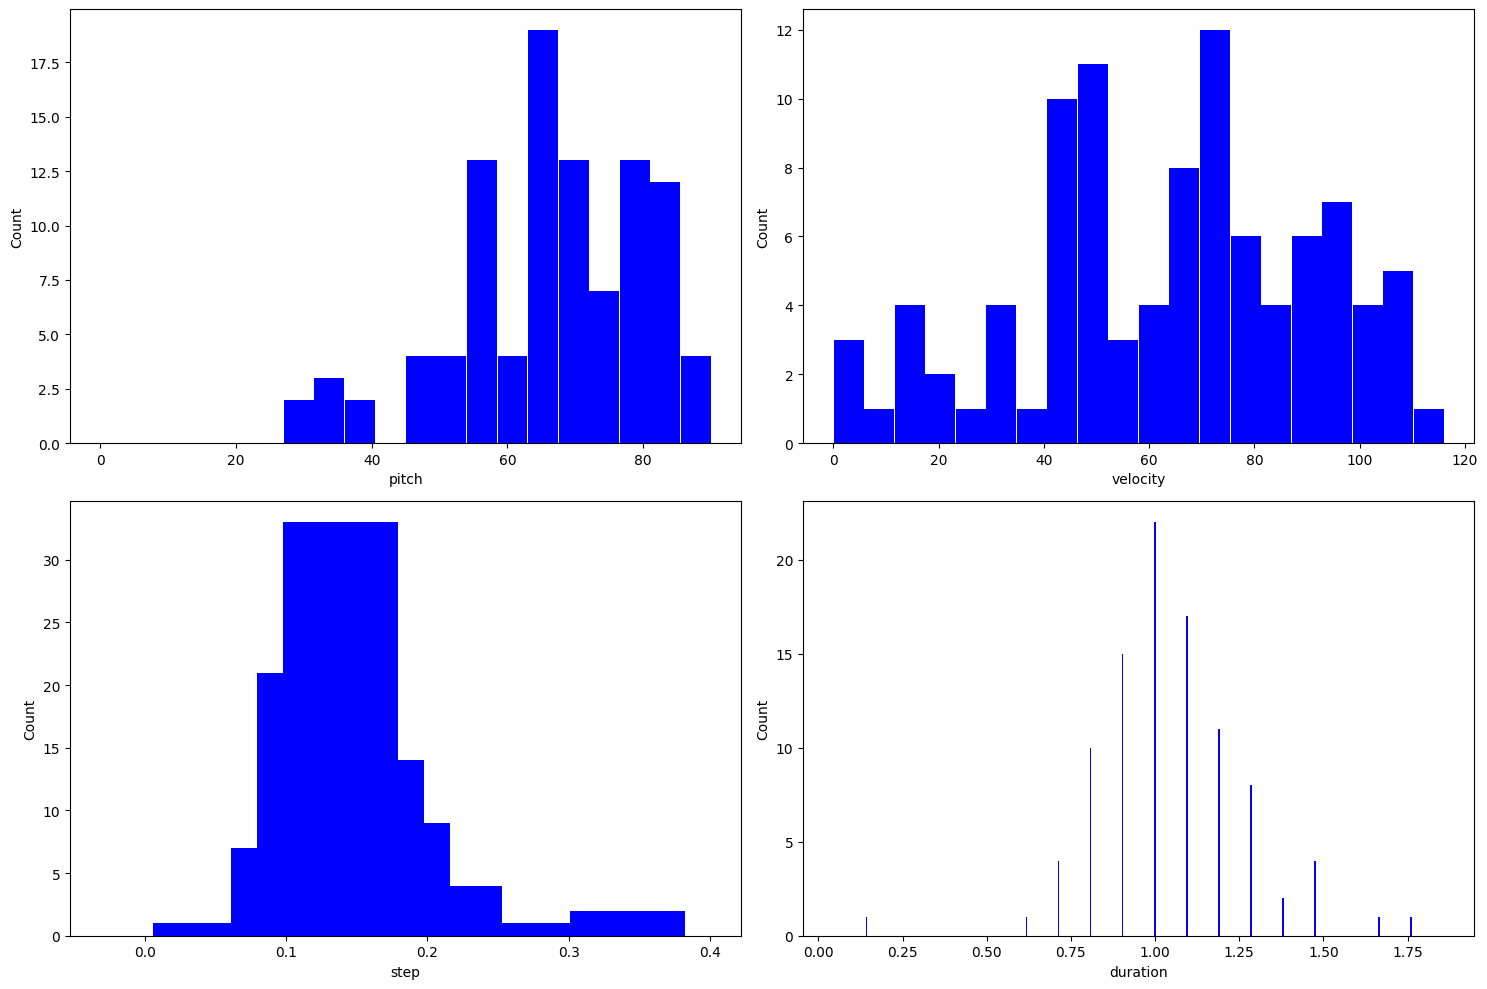

In [356]:
# get the last num_predictions v
generated_notes = all_notes.tail(num_predictions)
print(generated_notes.head())
plot_distributions(generated_notes)

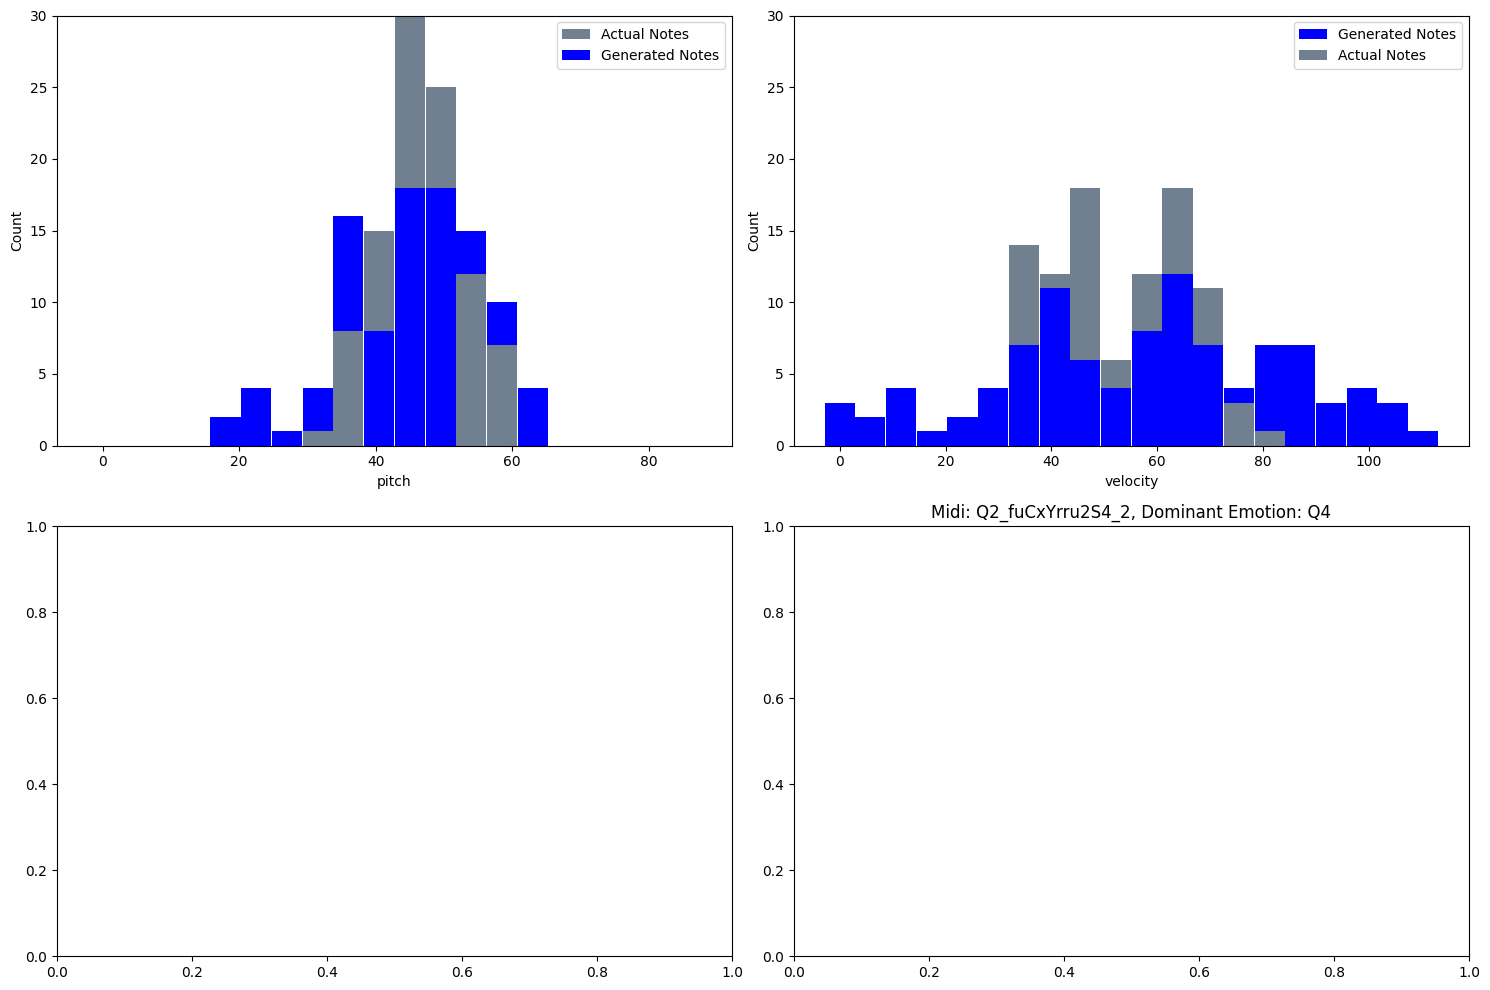

In [357]:
def plot_distributions(generated_df, actual_df, drop_percentile=2.5):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    colors = ['blue', 'slategrey']  # Colors for generated and actual notes

    # for col_idx, variable in enumerate(['pitch', 'velocity', 'step', 'duration']):
    for col_idx, variable in enumerate(['pitch', 'velocity']):
        # Ensure data for the variable exists in both DataFrames
        if variable in generated_df.columns and variable in actual_df.columns:
            # Calculate the max value for the variable, considering the drop_percentile for both datasets
            max_val = [
                np.percentile(generated_df[variable].dropna(), 100 - drop_percentile),
                np.percentile(actual_df[variable].dropna(), 100 - drop_percentile)
            ]
            bins = np.linspace(0, max(max_val), 21)
            bin_width = np.diff(bins)[0] - 0.1

            # Histogram for generated notes
            counts_gen, _ = np.histogram(generated_df[variable].dropna(), np.linspace(0, 127, 21))

            # Histogram for actual notes
            counts_act, _ = np.histogram(actual_df[variable].dropna(), np.linspace(0, 127, 21))

            # Plot histograms
            for b in range(len(bins)-1):
                # Determine which bar is taller
                taller_bar = 'gen' if counts_gen[b] > counts_act[b] else 'act'
                
                # Plot the taller bar
                if taller_bar == 'gen':
                    axes[col_idx // 2, col_idx % 2].bar(bins[b], counts_gen[b], width=bin_width, color=colors[0], label='Generated Notes' if b == 0 else "", alpha=1)
                else:
                    axes[col_idx // 2, col_idx % 2].bar(bins[b], counts_act[b], width=bin_width, color=colors[1], label='Actual Notes' if b == 0 else "", alpha=1)
                
                # Plot the shorter bar on top of the taller bar
                if taller_bar == 'gen':
                    axes[col_idx // 2, col_idx % 2].bar(bins[b], counts_act[b], width=bin_width, color=colors[1], label='Actual Notes' if b == 0 else "", alpha=1)
                else:
                    axes[col_idx // 2, col_idx % 2].bar(bins[b], counts_gen[b], width=bin_width, color=colors[0], label='Generated Notes' if b == 0 else "", alpha=1)

                # set ylim to 30
                axes[col_idx // 2, col_idx % 2].set_ylim(0, 30)

            # Set labels and add legend
            axes[col_idx // 2, col_idx % 2].set_xlabel(variable)
            axes[col_idx // 2, col_idx % 2].set_ylabel('Count')
            axes[col_idx // 2, col_idx % 2].legend()

    tle = f'Midi: Q2_fuCxYrru2S4_2, Dominant Emotion: Q{max_index + 1}'
    plt.title(tle)

    plt.tight_layout()
    # plt.savefig(f'{tle.replace(" ", "_")}.png')
    plt.show()

plot_distributions(generated_notes, initial_sequence_df)